# X.1. Optimizing the S&P 500

# Import Packages, Settings

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA

In [3]:
import os
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

In [4]:
LOADFILE = '../data/spx_returns_weekly.xlsx'
rets = pd.read_excel(LOADFILE, sheet_name='s&p500 rets').set_index('date')
FREQ = 52
rets = rets.iloc[:,::2]

In [5]:
GROSS_LIMIT = 4

In [6]:
Nt, Nk = rets.shape
ones = np.ones(Nt)

wts = pd.DataFrame(index = rets.columns,dtype=float) 
rp = pd.DataFrame(index = rets.index, dtype=float)

In [7]:
def penalized_reg_limit_gross(func, X, y, limit=2, penalty=1e-6, fit_intercept=True):
    wts = np.ones(X.shape[1]) * 100
    
    while np.abs(wts).sum()>limit:
        penalty *= 1.1
        model = func(alpha=penalty, fit_intercept=fit_intercept).fit(X,y)
        wts = model.coef_ / model.coef_.sum()
    
    return wts, penalty

### Equally Weighted

In [8]:
wts['equal'] = 1/Nk

### Risk Parity

In [9]:
wts['parity'] = 1/rets.std()

### MV

In [10]:
wts['mv'] = LinearRegression(fit_intercept=False).fit(rets,ones).coef_

In [11]:
wts['nonnegative'] = LinearRegression(fit_intercept=False,positive=True).fit(rets,ones).coef_

### Ridge

In [12]:
wts['ridge'], penalty_ridge = penalized_reg_limit_gross(Ridge,rets,ones,limit=GROSS_LIMIT,fit_intercept=False)

### LASSO

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    wts['lasso'], penalty_lasso = penalized_reg_limit_gross(Lasso,rets,ones,limit=GROSS_LIMIT,fit_intercept=False)

## Performance

In [14]:
wts /= wts.sum()
rp = rets @ wts
performanceMetrics(rp,annualization=FREQ)

,Mean,Vol,Sharpe,Min,Max
equal,0.1873,0.1941,0.9650,-0.1674,0.1689
parity,0.1779,0.1824,0.9754,-0.1592,0.1561
mv,1.5910,0.2281,6.9746,-0.0824,0.1142
nonnegative,0.4303,0.2223,1.9359,-0.1162,0.1243
ridge,0.6534,0.2418,2.7016,-0.1189,0.1218
lasso,1.0078,0.3670,2.7459,-0.1325,0.1883


In [15]:
tailMetrics(rp)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
equal,-0.3697,11.9494,-0.0372,-0.0641,-0.3589,2020-02-14,2020-03-20,2020-08-28,196 days
parity,-0.4541,11.9424,-0.0353,-0.0605,-0.3372,2020-02-14,2020-03-20,2020-08-28,196 days
mv,-0.2067,0.1599,-0.0226,-0.0381,-0.0824,2018-06-29,2018-07-06,2018-07-20,21 days
nonnegative,-0.2900,2.4098,-0.0399,-0.0640,-0.2662,2020-02-21,2020-03-20,2020-05-08,77 days
ridge,-0.2311,1.4241,-0.0420,-0.0650,-0.2088,2020-02-21,2020-03-20,2020-04-17,56 days
lasso,0.1393,0.3992,-0.0601,-0.0837,-0.1912,2020-03-06,2020-03-20,2020-04-10,35 days


In [16]:
get_ols_metrics(rp['equal'],rp,annualization=FREQ)

,alpha,equal,r-squared,Treynor Ratio,Info Ratio
equal,0.0000,1.0000,1.0000,0.1873,NaN
parity,0.0023,0.9376,0.9952,0.1898,0.1834
mv,1.5606,0.1626,0.0191,9.7853,6.9075
nonnegative,0.2612,0.9026,0.6213,0.4767,1.9098
ridge,0.5025,0.8055,0.4180,0.8111,2.7234
lasso,0.8376,0.9089,0.2311,1.1089,2.6025


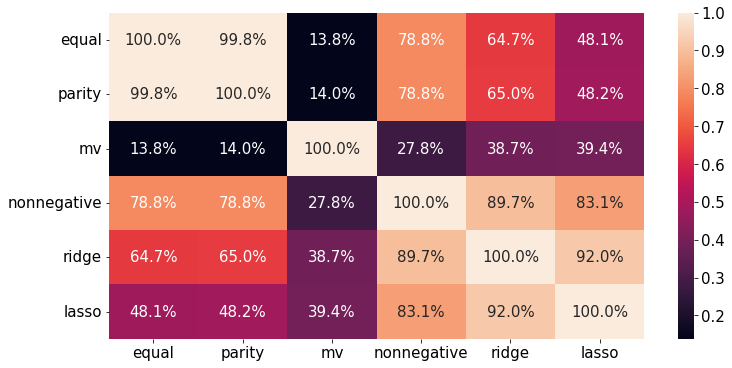

In [17]:
sns.heatmap(rp.corr(),annot=True,fmt='.1%');

## Understanding the Methods

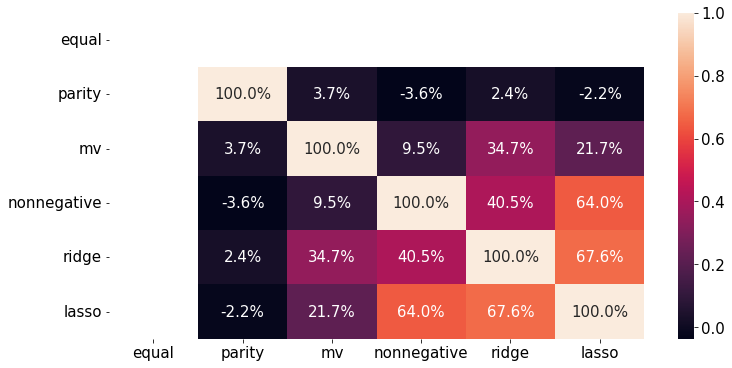

In [18]:
sns.heatmap(wts.corr(),annot=True,fmt='.1%');

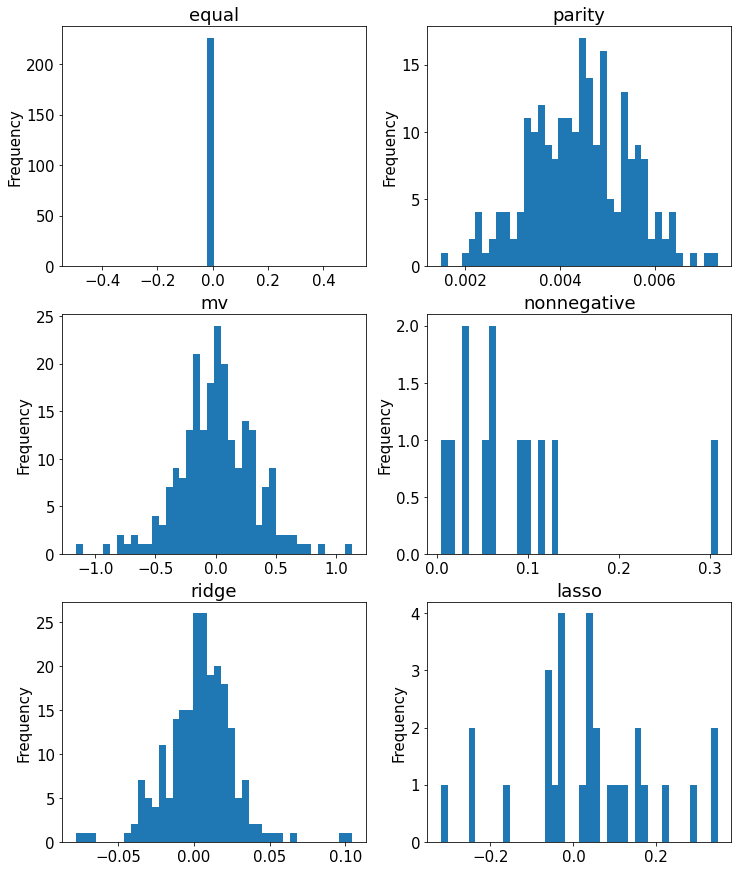

In [19]:
plotwts = wts.copy()
plotwts[plotwts.abs()<1e-4] = np.nan

fig, ax = plt.subplots(3,2,figsize=(12,15))
wmin = plotwts.min().min()
wmax = plotwts.max().max()
for i,method in enumerate(plotwts.columns):
    idplot = [int(np.floor(i/2)),i%2]
    plotwts[method].plot.hist(ax=ax[idplot[0],idplot[1]],bins=40,title=method)#,xlim=(wmin,wmax))

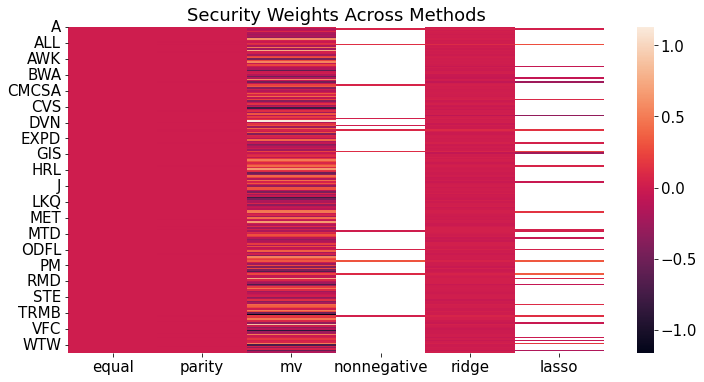

In [20]:
sns.heatmap(plotwts)
plt.title('Security Weights Across Methods')
plt.show()

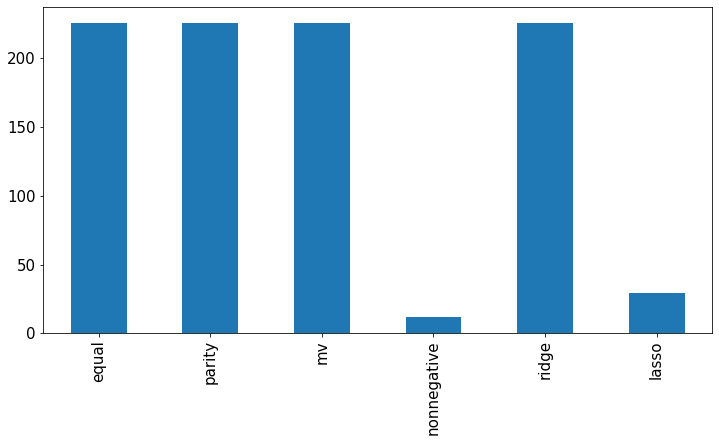

In [21]:
(wts.abs()>1e-4).sum().plot.bar();

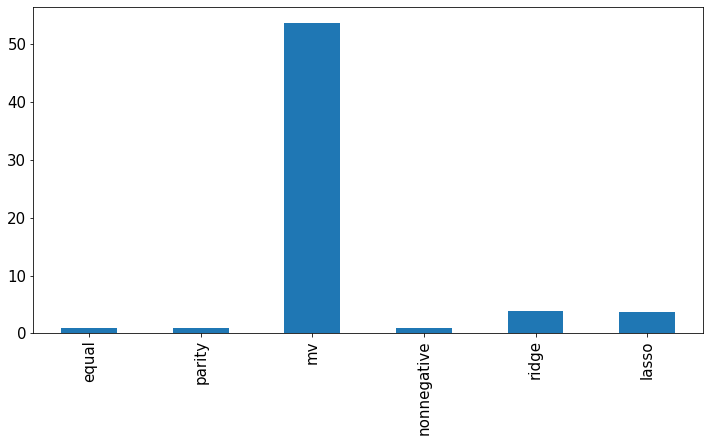

In [22]:
wts.abs().sum().plot.bar();

# Out of Sample

In [23]:
ADJUST_PENALTY = False
GROSS_LIMIT = 2

Nassets = Nk

minT = FREQ*4
methods = wts.columns

# initialize
wts_oos = pd.concat([pd.DataFrame(index=rets.index, columns=rets.columns)]*len(methods), keys=methods, axis=1)
equal_wts = np.ones(Nassets) / Nassets

In [24]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for t in wts_oos.index:    
        R = rets.loc[:t,:]
        y = np.ones(R.shape[0])

        if R.shape[0] >= minT:
            wts_oos.loc[t,'equal',] = equal_wts
            if 'SPY' in R.columns:
                wts_oos.loc[t,'SPY',] = 0
                wts_oos.loc[t,('SPY','SPY')] = 1

            wts_oos.loc[t,'mv',] = LinearRegression(fit_intercept=False).fit(R,y).coef_
            wts_oos.loc[t,'nonnegative',] = LinearRegression(positive=True, fit_intercept=False).fit(R,y).coef_    
            wts_oos.loc[t,'ridge',] = Ridge(alpha= penalty_ridge, fit_intercept=False).fit(R,y).coef_
            wts_oos.loc[t,'lasso',] = Lasso(alpha= penalty_lasso, fit_intercept=False).fit(R,y).coef_

            # dynamically adjust the penalty parameter
            # takes longer to run, brings gross leverage down
            if ADJUST_PENALTY:
                betas, penalty_ridge = penalized_reg_limit_gross(Ridge, R, y, limit=GROSS_LIMIT, fit_intercept=False)
                betas, penalty_lasso = penalized_reg_limit_gross(Lasso, R, y, limit=GROSS_LIMIT, fit_intercept=False)

for method in methods:
    div_factor = wts_oos[method].sum(axis=1)
    div_factor[div_factor==0] = 1
    wts_oos[method] = wts_oos[method].div(div_factor, axis='rows')

wts_oos_lag = wts_oos.shift(1)

CPU times: user 46.5 s, sys: 27.7 s, total: 1min 14s
Wall time: 13.3 s


In [25]:
rets_port_oos = pd.DataFrame(index=rets.index, columns = methods)

for method in methods:    
    rets_port_oos[method] = (wts_oos_lag[method] * rets).sum(axis=1)

# do not count burn-in period
rets_port_oos.iloc[:minT,:] = None

In [26]:
display(performanceMetrics(rets_port_oos, annualization=12).style.format('{:.2%}'.format))
display(tailMetrics(rets_port_oos))
display(get_ols_metrics(rp['equal'], rets_port_oos,annualization=12).style.format('{:.2%}'.format))

,Mean,Vol,Sharpe,Min,Max
equal,3.92%,13.11%,29.88%,-16.74%,16.89%
parity,0.00%,0.00%,nan%,0.00%,0.00%
mv,47.28%,295.14%,16.02%,-284.29%,553.60%
nonnegative,3.91%,13.49%,29.02%,-14.46%,11.29%
ridge,3.43%,19.68%,17.43%,-18.38%,15.98%
lasso,4.36%,34.37%,12.69%,-47.06%,26.42%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
equal,-0.2396,7.0188,-0.0491,-0.0901,-0.3589,2020-02-14,2020-03-20,2020-08-28,196 days
parity,0.0000,0.0000,0.0000,NaN,0.0000,2020-01-10,2020-01-10,2020-01-10,0 days
mv,2.3654,15.9931,-0.7277,-1.6596,-5.0476,2020-02-28,2020-04-10,NaT,NaT
nonnegative,-0.4369,2.4165,-0.0528,-0.0871,-0.3058,2020-02-21,2020-03-20,2020-07-17,147 days
ridge,-0.4361,0.9392,-0.0919,-0.1308,-0.3467,2021-11-19,2022-05-20,NaT,NaT
lasso,-1.0954,4.4387,-0.1743,-0.2509,-0.6910,2020-11-06,2021-06-04,NaT,NaT


,alpha,equal,r-squared,Treynor Ratio,Info Ratio
equal,0.00%,100.00%,100.00%,4.32%,nan%
parity,0.00%,-0.00%,100.00%,nan%,nan%
mv,51.21%,-100.39%,0.20%,-47.09%,17.37%
nonnegative,0.84%,78.45%,58.19%,4.99%,9.63%
ridge,1.56%,47.65%,10.08%,7.20%,8.38%
lasso,3.46%,23.03%,0.77%,18.94%,10.11%


In [27]:
wts_all = wts_oos.unstack().groupby(level=(0,2))
wts_all_diff = wts_oos.diff().unstack().groupby(level=(0,2))

gross_leverage = wts_all.apply(lambda x: sum(abs(x))).unstack(level=0)
turnover = wts_all_diff.apply(lambda x: sum(abs(x))).unstack(level=0)
num_positions = wts_all.apply(lambda x: sum(abs(x)>0)).unstack(level=0)
max_wt = wts_all.apply(lambda x: max(x)).unstack(level=0)
min_wt = wts_all.apply(lambda x: min(x)).unstack(level=0)

dates_active = (rets.index[minT],rets.index[-1])

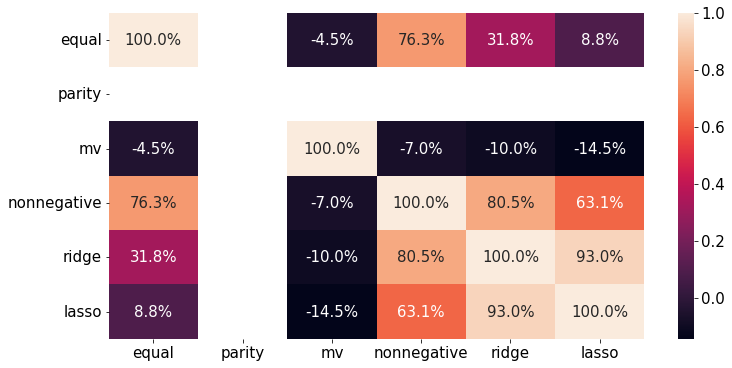

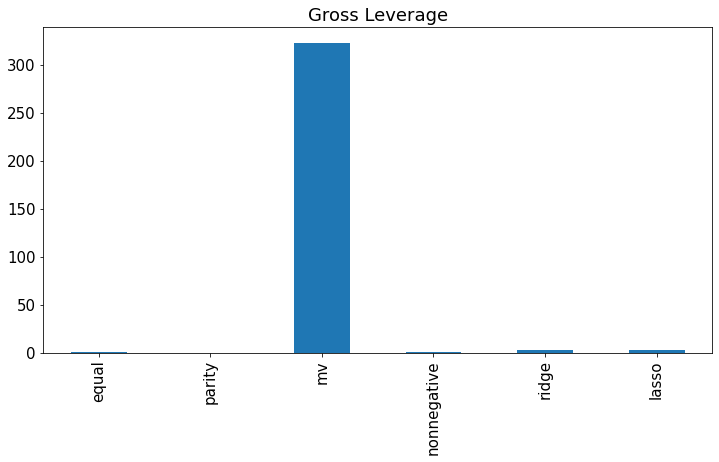

In [28]:
sns.heatmap(rets_port_oos.corr(),annot=True,fmt='.1%')
plt.show()
gross_leverage.mean().plot.bar(title='Gross Leverage');

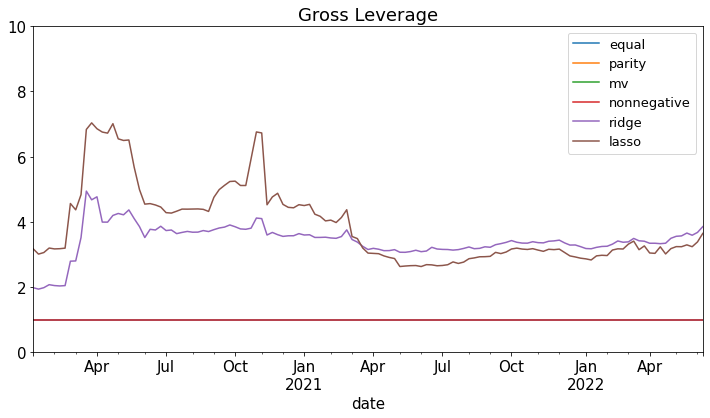

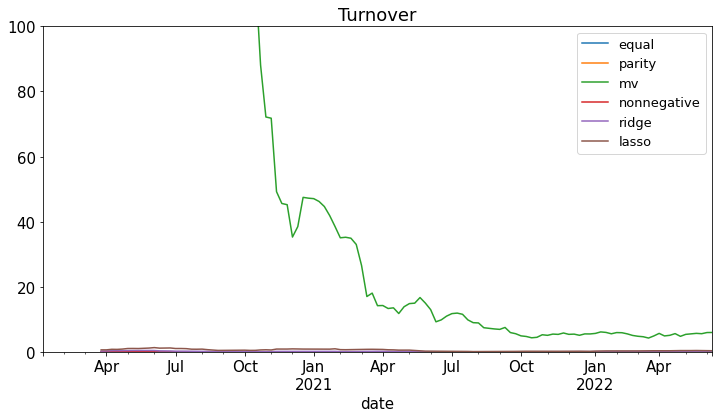

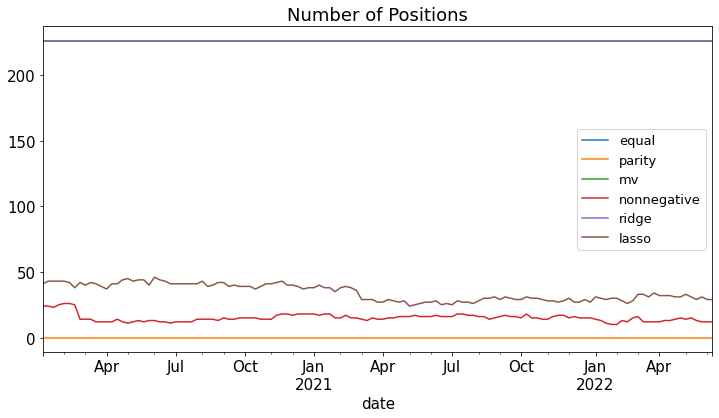

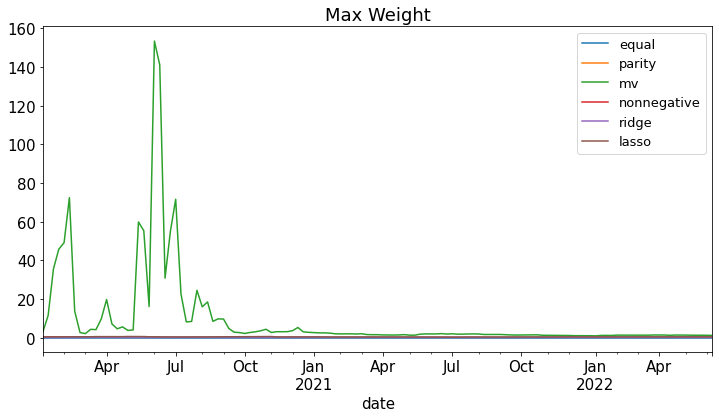

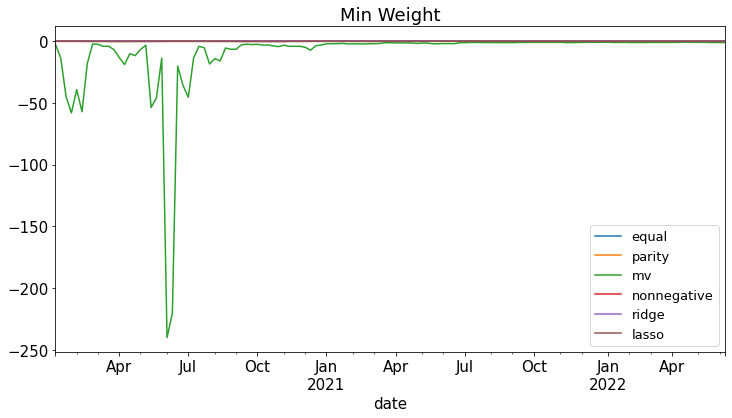

In [29]:
gross_leverage.plot(title='Gross Leverage',xlim=dates_active)
plt.ylim(0,10)
turnover.rolling(12*1).mean().plot(title='Turnover',xlim=dates_active)
plt.ylim(0,100)
plt.show()

num_positions.plot(title='Number of Positions',xlim=dates_active)
max_wt.plot(title='Max Weight',xlim=dates_active)
plt.show()
min_wt.plot(title='Min Weight',xlim=dates_active)
plt.show()